In [251]:
import torch
import matplotlib.pyplot as plt
import numpy as np

In [252]:
torch.manual_seed(30)
torch.set_default_dtype(torch.float64)

In [253]:
def u_exact(x:torch.Tensor):
    u_g = x**3/(0.01 + x**4)
    return u_g

def calculate_kappa(x):
    nb_zeros = torch.where(x[:-1, 0] * x[1:, 0] < 0)[0]
    kappa = 3*(nb_zeros.shape[0])
    return kappa

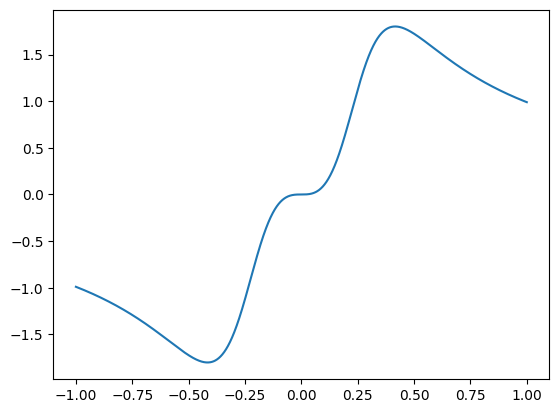

In [254]:
nb_training_points = 1501
x_train0 = torch.linspace(-1.02, 1.02, nb_training_points).reshape(-1,1)
u_train0 = u_exact(x_train0)

low_bound_xtrain, up_bound_xtrain = x_train0.min(), x_train0.max()

nb_evaluation_points = 8000
x_eval = torch.linspace(-1, 1, nb_evaluation_points).reshape(-1,1)
u_eval = u_exact(x_eval)

plt.plot(x_eval, u_eval, label='Exact solution')

In [268]:
class SinActivation(torch.nn.Module):
    def __init__(self) -> None:
        super(SinActivation, self).__init__()

    def forward(self, x):
        return torch.sin(x)
    
class FullyConnectedNN(torch.nn.Module):
    def __init__(self, x_train, u_train, layers, kappa, low_bound_xtrain, up_bound_xtrain, actv=0) -> None:
        super(FullyConnectedNN, self).__init__()

        self.u_scale = torch.max(torch.abs(u_train))/2
        self.loss_scale = self.u_scale**2
        self.x_train = x_train
        self.u_train = u_train/self.u_scale

        self.lb, self.up = low_bound_xtrain, up_bound_xtrain
        self.n_layers = len(layers)

        self.kappa = kappa
        self.first_activation = [torch.nn.Tanh(), SinActivation()][actv]
        self.activation = torch.nn.Tanh()

        self.weights, self.biases = self._initialize_weights(layers)

    def _initialize_weights(self, layers):
        weights, biases = [], []
        for i in range(len(layers)-1):
            W = torch.nn.Parameter(self._weight_matrix(size_in=layers[i], size_out=layers[i+1]))
            b = torch.nn.Parameter(torch.zeros(layers[i+1], 1))
            weights.append(W)
            biases.append(b)
        return torch.nn.ParameterList(weights), torch.nn.ParameterList(biases)
    
    def _weight_matrix(self, size_in, size_out):
        std = np.sqrt(2/(size_in + size_out))
        return torch.nn.init.trunc_normal_(torch.empty(size_in, size_out), std=std)
    
    def forward(self, x):
        weights = self.weights
        biases = self.biases
        x_normalized = 2*(x - self.lb)/(self.up - self.lb) - 1

        W, b = weights[0], biases[0]
        x_forwarded = self.first_activation(self.kappa*(x_normalized @ W) + b.T)

        for i in range(1, self.n_layers-2):
            W, b = weights[i], biases[i]
            x_forwarded = self.activation(self.kappa*(x_forwarded @ W) + b.T)

        W, b = weights[-1], biases[-1]
        u_theta = x_forwarded @ W + b.T
        return u_theta
    
    def train(self, n_iter):
        criterion = torch.nn.MSELoss()
        model_optimizer = torch.optim.Adam(self.parameters(), lr=0.0005)

        for iter_i in range(n_iter): 
            model_optimizer.zero_grad()

            u_pred = self.forward(self.x_train)
            loss = criterion(u_pred, self.u_train)*self.loss_scale 
            
            loss.backward()
            model_optimizer.step()

            if iter_i % 100 == 0:
                print(f'Iter {iter_i}, Loss: {loss.item()}')

    def predict(self, x):
        return self.u_scale*self.forward(x)

In [256]:
model1 = FullyConnectedNN(x_train=x_train0, u_train=u_train0, layers=[1, 20, 20, 20, 1], kappa=1, low_bound_xtrain=low_bound_xtrain, up_bound_xtrain=up_bound_xtrain, actv=0)
model1.train(10000)
u_pred0 = model1.predict(x_eval)

Iter 0, Loss: 1.2638328123301938
Iter 100, Loss: 0.2913320190344452
Iter 200, Loss: 0.2609765546068271
Iter 300, Loss: 0.19223767979449247
Iter 400, Loss: 0.0980999910136755
Iter 500, Loss: 0.060213814848626764
Iter 600, Loss: 0.04681324083571377
Iter 700, Loss: 0.03875707072124605
Iter 800, Loss: 0.03366788123208749
Iter 900, Loss: 0.02991706261305793
Iter 1000, Loss: 0.026406203138475914
Iter 1100, Loss: 0.022801463697625885
Iter 1200, Loss: 0.01861143313760087
Iter 1300, Loss: 0.013912224963044027
Iter 1400, Loss: 0.009751919791057124
Iter 1500, Loss: 0.006539099790543895
Iter 1600, Loss: 0.004308782125280257
Iter 1700, Loss: 0.0028573341500419997
Iter 1800, Loss: 0.001929752384789336
Iter 1900, Loss: 0.0013146994924976378
Iter 2000, Loss: 0.000873286428206837
Iter 2100, Loss: 0.000586237195447091
Iter 2200, Loss: 0.0004020342900737309
Iter 2300, Loss: 0.00028121227883939133
Iter 2400, Loss: 0.00020301013357622375
Iter 2500, Loss: 0.00015281553726689245
Iter 2600, Loss: 0.0001202113

In [265]:
u0 = model1.predict(x_train0).detach()
error_1 = u_train0 - u0
epsilon1 = torch.sqrt(torch.mean(error_1**2))
u_train1 = error_1/epsilon1
kappa2 = calculate_kappa(u_train1)

print(f'Le coefficient kappa2 vaut: {kappa2}')

model2 = FullyConnectedNN(x_train=x_train0, u_train=u_train1, layers=[1, 20, 20, 20, 1], kappa=kappa2, low_bound_xtrain=low_bound_xtrain, up_bound_xtrain=up_bound_xtrain, actv=1)
model2.train(10000)
u_pred1 = model2.predict(x_eval)
u_p = u_pred0 + epsilon1*u_pred1

Le coefficient kappa2 vaut: 45
Iter 0, Loss: 13.835519180359274
Iter 100, Loss: 3.3234408685734964
Iter 200, Loss: 2.3432375538212518
Iter 300, Loss: 1.7681225614860148
Iter 400, Loss: 1.5089535590340297
Iter 500, Loss: 1.2937936545918085
Iter 600, Loss: 1.1701472695148294
Iter 700, Loss: 1.051924225036499
Iter 800, Loss: 0.9183557073301354
Iter 900, Loss: 0.8061639715126662
Iter 1000, Loss: 0.6906030794061938
Iter 1100, Loss: 0.649380677559435
Iter 1200, Loss: 0.4419504858659056
Iter 1300, Loss: 0.39402725752364975
Iter 1400, Loss: 0.3514169466872839
Iter 1500, Loss: 0.3164690023426445
Iter 1600, Loss: 0.2927288339915501
Iter 1700, Loss: 0.2720557993052087
Iter 1800, Loss: 0.254690679212181
Iter 1900, Loss: 0.2310383929148369
Iter 2000, Loss: 0.22681753405537802
Iter 2100, Loss: 0.21875257785961916
Iter 2200, Loss: 0.1760530026369226
Iter 2300, Loss: 0.17539268231139896
Iter 2400, Loss: 0.18206259023476926
Iter 2500, Loss: 0.14534546607729154
Iter 2600, Loss: 0.14151450350804745
Iter 

In [266]:
u1 = model2.predict(x_train0).detach()

Text(0.5, 1.0, 'Residue order 1')

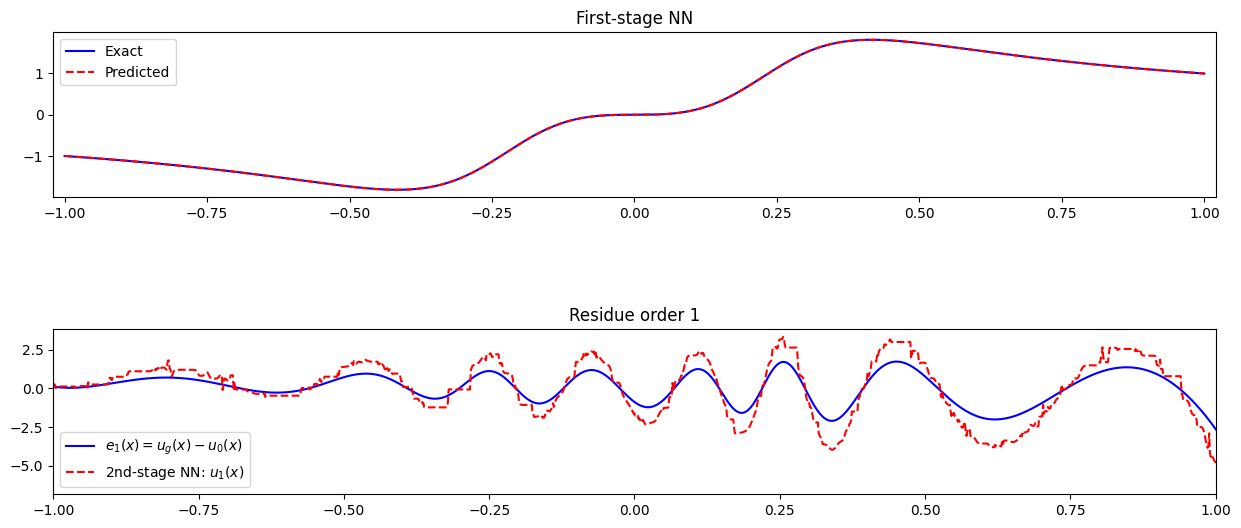

In [267]:
fig, axes = plt.subplots(2, 1, figsize=(15, 6))
fig.subplots_adjust(hspace=0.8)

axes[0].plot(x_eval, u_eval, 'b-', label='Exact')
axes[0].plot(x_eval, u_pred0.detach(), 'r--', label='Predicted')
axes[0].set_xlim(low_bound_xtrain, up_bound_xtrain)
axes[0].legend()
axes[0].set_title('First-stage NN')

axes[1].plot(x_train0, u_train1.detach(), 'b-', label=r'$e_1(x) = u_g(x) - u_0(x)$')
axes[1].plot(x_train0, u1, 'r--', label=r'2nd-stage NN: $u_1(x)$')
axes[1].set_xlim(-1, 1)
axes[1].legend()
axes[1].set_title('Residue order 1')
